# Vehicle Routing Problem with Time Windows (VRPTW)

Adaptation from Google's example given in https://developers.google.com/optimization/routing/vrptw.html

In [2]:
# [START import]
from __future__ import print_function

from ortools.constraint_solver import routing_enums_pb2
from ortools.constraint_solver import pywrapcp

import numpy as np
import matplotlib.pyplot as plt
import networkx as nx

import xml.etree.ElementTree as ET
# [END import]

In [4]:
# [START import instance]
instanceName = 'd1c5cs4_ev4.xml'

tree = ET.parse(instanceName)
nodes = tree.find('network').find('nodes')
arcs = tree.find('network').find('arcs')

networkSize = len(nodes)

nodes_id = [int(x.get('id')) for x in nodes]
timeMatrix = np.zeros((networkSize, networkSize))
energyMatrix = np.zeros((networkSize, networkSize))
coordinates = {}

for i, nodeFrom in enumerate(arcs):
    for j, nodeTo in enumerate(nodeFrom):
        timeMatrix[i][j] = float(nodeTo[0].text)
        energyMatrix[i][j] = float(nodeTo[1].text)
    coordinates[i] = (float(nodes[i].find('cx').text), float(nodes[i].find('cy').text))

print('NODES IDSs:\n', nodes_id)
print('RESULTING TIME MATRIX:\n', timeMatrix)
print('RESULTING ENERGY CONSUMPTION MATRIX:\n', energyMatrix)
print('RESULTING NODES COORDINATES:\n',coordinates)
# [END import instance]

NODES IDSs:
 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
RESULTING TIME MATRIX:
 [[ 0.   13.95 22.01 10.73 13.4   7.92 22.41 34.62 15.   14.28]
 [25.97  0.   11.24  9.07 28.53 32.91 25.76 23.42 19.45  9.64]
 [31.85  8.97  0.    3.15  8.56 15.1  22.93 29.22  8.65 12.94]
 [27.39 22.23  4.19  0.   23.5  34.47 30.34 30.78  5.28 16.07]
 [22.63 32.33 28.93 12.11  0.   32.45 24.78 20.64 31.77 28.57]
 [20.31 17.15 22.32 24.8  23.02  0.   19.83 29.   23.71 34.63]
 [22.34 29.86 15.57 34.54 17.42 19.5   0.   29.09 26.34 24.01]
 [ 9.95 17.03 19.71 11.51 23.96 31.95  7.75  0.    6.9  23.34]
 [22.92  7.14  9.08 31.57 30.03 20.66  6.39 27.86  0.   12.65]
 [ 5.07 14.08 17.31 13.85 33.13 15.07 21.04 19.23 11.67  0.  ]]
RESULTING ENERGY CONSUMPTION MATRIX:
 [[0.   3.98 8.63 6.08 4.59 2.32 7.56 6.58 8.87 8.79]
 [8.8  0.   7.06 5.12 9.19 8.92 4.36 4.16 5.9  7.04]
 [2.19 8.89 0.   7.14 6.87 2.17 6.23 4.2  9.81 9.04]
 [2.26 3.83 6.23 0.   6.51 5.29 5.87 6.77 9.3  3.49]
 [2.67 7.41 3.88 4.81 0.   3.76 3.03 9.23 5.6  5.41

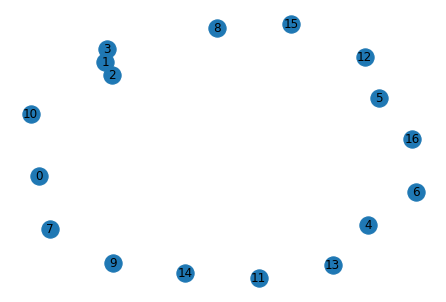

In [20]:
# [START data_model]
def create_data_model(path=None):
    """Stores the data for the problem."""
    if path:
        tree = ET.parse(path)
        nodes = tree.find('network').find('nodes')
        arcs = tree.find('network').find('arcs')

        networkSize = len(nodes)

        nodes_id = [int(x.get('id')) for x in nodes]
        timeMatrix = np.zeros((networkSize, networkSize))
        energyMatrix = np.zeros((networkSize, networkSize))
        coordinates = {}

        for i, nodeFrom in enumerate(arcs):
            for j, nodeTo in enumerate(nodeFrom):
                timeMatrix[i][j] = float(nodeTo[0].text)
                energyMatrix[i][j] = float(nodeTo[1].text)
            coordinates[i] = (float(nodes[i].find('cx').text), float(nodes[i].find('cy').text))

        print('NODES IDSs:\n', nodes_id)
        print('RESULTING TIME MATRIX:\n', timeMatrix)
        print('RESULTING ENERGY CONSUMPTION MATRIX:\n', energyMatrix)
        print('RESULTING NODES COORDINATES:\n',coordinates)
        data = {}
        data['time_matrix'] = timeMatrix
        data['time_Windows'] = []
        data['num_vehicles'] = 4
        data['depot'] = 0
        data['nodes'] = range(0, len(nodes))
        data['edges'] = [(1,2), (1,3)]
    else:
        data = {}
        data['time_matrix'] = [
            [0, 6, 9, 8, 7, 3, 6, 2, 3, 2, 6, 6, 4, 4, 5, 9, 7],
            [6, 0, 8, 3, 2, 6, 8, 4, 8, 8, 13, 7, 5, 8, 12, 10, 14],
            [9, 8, 0, 11, 10, 6, 3, 9, 5, 8, 4, 15, 14, 13, 9, 18, 9],
            [8, 3, 11, 0, 1, 7, 10, 6, 10, 10, 14, 6, 7, 9, 14, 6, 16],
            [7, 2, 10, 1, 0, 6, 9, 4, 8, 9, 13, 4, 6, 8, 12, 8, 14],
            [3, 6, 6, 7, 6, 0, 2, 3, 2, 2, 7, 9, 7, 7, 6, 12, 8],
            [6, 8, 3, 10, 9, 2, 0, 6, 2, 5, 4, 12, 10, 10, 6, 15, 5],
            [2, 4, 9, 6, 4, 3, 6, 0, 4, 4, 8, 5, 4, 3, 7, 8, 10],
            [3, 8, 5, 10, 8, 2, 2, 4, 0, 3, 4, 9, 8, 7, 3, 13, 6],
            [2, 8, 8, 10, 9, 2, 5, 4, 3, 0, 4, 6, 5, 4, 3, 9, 5],
            [6, 13, 4, 14, 13, 7, 4, 8, 4, 4, 0, 10, 9, 8, 4, 13, 4],
            [6, 7, 15, 6, 4, 9, 12, 5, 9, 6, 10, 0, 1, 3, 7, 3, 10],
            [4, 5, 14, 7, 6, 7, 10, 4, 8, 5, 9, 1, 0, 2, 6, 4, 8],
            [4, 8, 13, 9, 8, 7, 10, 3, 7, 4, 8, 3, 2, 0, 4, 5, 6],
            [5, 12, 9, 14, 12, 6, 6, 7, 3, 3, 4, 7, 6, 4, 0, 9, 2],
            [9, 10, 18, 6, 8, 12, 15, 8, 13, 9, 13, 3, 4, 5, 9, 0, 9],
            [7, 14, 9, 16, 14, 8, 5, 10, 6, 5, 4, 10, 8, 6, 2, 9, 0],
        ]
        data['time_windows'] = [
            (0, 5),  # depot
            (7, 12),  # 1
            (10, 15),  # 2
            (5, 14),  # 3
            (5, 13),  # 4
            (0, 5),  # 5
            (5, 10),  # 6
            (0, 10),  # 7
            (5, 10),  # 8
            (0, 5),  # 9
            (10, 16),  # 10
            (10, 15),  # 11
            (0, 5),  # 12
            (5, 10),  # 13
            (7, 12),  # 14
            (10, 15),  # 15
            (5, 15),  # 16
        ]
        data['num_vehicles'] = 4
        data['depot'] = 0
        data['nodes'] = range(0, 17)
        data['edges'] = [(1,2), (1,3)]
    return data
# [END data_model]

data = create_data_model()

In [3]:
# [START solution_printer]
def print_solution(data, manager, routing, assignment):
    """Prints assignment on console."""
    time_dimension = routing.GetDimensionOrDie('Time')
    total_time = 0
    for vehicle_id in range(data['num_vehicles']):
        index = routing.Start(vehicle_id)
        plan_output = 'Route for vehicle {}:\n'.format(vehicle_id)
        while not routing.IsEnd(index):
            time_var = time_dimension.CumulVar(index)
            plan_output += '{0} Time({1},{2}) -> '.format(
                manager.IndexToNode(index), assignment.Min(time_var),
                assignment.Max(time_var))
            index = assignment.Value(routing.NextVar(index))
        time_var = time_dimension.CumulVar(index)
        plan_output += '{0} Time({1},{2})\n'.format(manager.IndexToNode(index),
                                                    assignment.Min(time_var),
                                                    assignment.Max(time_var))
        plan_output += 'Time of the route: {}min\n'.format(
            assignment.Min(time_var))
        print(plan_output)
        total_time += assignment.Min(time_var)
    print('Total time of all routes: {}min'.format(total_time))
# [END solution_printer]

In [4]:
# [START definition_of_main_program]
def main():
    """Solve the VRP with time windows."""
    # Instantiate the data problem.
    # [START data]
    data = create_data_model()
    # [END data]

    # Create the routing index manager.
    # [START index_manager]
    manager = pywrapcp.RoutingIndexManager(len(data['time_matrix']),
                                           data['num_vehicles'], data['depot'])
    # [END index_manager]

    # Create Routing Model.
    # [START routing_model]
    routing = pywrapcp.RoutingModel(manager)

    # [END routing_model]

    # Create and register a transit callback.
    # [START transit_callback]
    def time_callback(from_index, to_index):
        """Returns the travel time between the two nodes."""
        # Convert from routing variable Index to time matrix NodeIndex.
        from_node = manager.IndexToNode(from_index)
        to_node = manager.IndexToNode(to_index)
        return data['time_matrix'][from_node][to_node]

    transit_callback_index = routing.RegisterTransitCallback(time_callback)
    # [END transit_callback]

    # Define cost of each arc.
    # [START arc_cost]
    routing.SetArcCostEvaluatorOfAllVehicles(transit_callback_index)
    # [END arc_cost]

    # Add Time Windows constraint.
    # [START time_windows_constraint]
    time = 'Time'
    routing.AddDimension(
        transit_callback_index,
        30,  # allow waiting time
        30,  # maximum time per vehicle
        False,  # Don't force start cumul to zero.
        time)
    time_dimension = routing.GetDimensionOrDie(time)
    # Add time window constraints for each location except depot.
    for location_idx, time_window in enumerate(data['time_windows']):
        if location_idx == 0:
            continue
        index = manager.NodeToIndex(location_idx)
        time_dimension.CumulVar(index).SetRange(time_window[0], time_window[1])
    # Add time window constraints for each vehicle start node.
    for vehicle_id in range(data['num_vehicles']):
        index = routing.Start(vehicle_id)
        time_dimension.CumulVar(index).SetRange(data['time_windows'][0][0],
                                                data['time_windows'][0][1])
    # [END time_windows_constraint]

    # Instantiate route start and end times to produce feasible times.
    # [START depot_start_end_times]
    for i in range(data['num_vehicles']):
        routing.AddVariableMinimizedByFinalizer(
            time_dimension.CumulVar(routing.Start(i)))
        routing.AddVariableMinimizedByFinalizer(
            time_dimension.CumulVar(routing.End(i)))
    # [END depot_start_end_times]

    # Setting first solution heuristic.
    # [START parameters]
    search_parameters = pywrapcp.DefaultRoutingSearchParameters()
    search_parameters.first_solution_strategy = (
        routing_enums_pb2.FirstSolutionStrategy.PATH_CHEAPEST_ARC)
    # [END parameters]

    # Solve the problem.
    # [START solve]
    assignment = routing.SolveWithParameters(search_parameters)
    # [END solve]

    # Print solution on console.
    # [START print_solution]
    if assignment:
        print_solution(data, manager, routing, assignment)
    # [END print_solution]
# [END definition_of_main_program]

In [5]:
if __name__ == '__main__':
    main()

Route for vehicle 0:
0 Time(0,0) -> 9 Time(2,4) -> 14 Time(7,7) -> 16 Time(9,9) -> 0 Time(16,16)
Time of the route: 16min

Route for vehicle 1:
0 Time(0,0) -> 7 Time(2,2) -> 4 Time(6,6) -> 3 Time(7,7) -> 1 Time(10,10) -> 0 Time(16,16)
Time of the route: 16min

Route for vehicle 2:
0 Time(0,0) -> 12 Time(4,4) -> 13 Time(6,6) -> 15 Time(11,11) -> 11 Time(14,14) -> 0 Time(20,20)
Time of the route: 20min

Route for vehicle 3:
0 Time(0,0) -> 5 Time(3,3) -> 8 Time(5,5) -> 6 Time(7,7) -> 2 Time(10,10) -> 10 Time(14,14) -> 0 Time(20,20)
Time of the route: 20min

Total time of all routes: 72min
